# Replication

I cant find model weights, only the layers of the final quanitzed model 

Instead I will replicate the architecture and the way training data was split etc

Training Input is everything except classification

Data is scaled in the following ways:
- pT ([:,:,0]) Is z-scaled (x - mean)/std : They say they bring all to O(1) but not how so this seems reasonable
- eta and phi are tanh scaled : tanh(x / x_b) where x_b is the max(abs(x)) for non padded entries : This is only done before the MSE loss, implementing this for KL is very non trivial 

Models are constructed as classes with the encoder and decoder created as submodels

So if we have a full model say CNN_VAE we access the encoder with either CNN_VAE.layers[0] or CNN_VAE.get_layer("cnn_encoder"), but check what the actual name is, the submodel extracted then has the same methods available

The MSE loss and masked MSE loss is handled as functions that require a partial to work due to the way tensorflow works

The beta parameter managing the balance between MSE and KL is not defined in the paper -> A number of values are trialed and the best is selected -> Note that this is non exhaustive of a search and only done to order of magnitude not to exact value

Also note that if you run this and an error occurs during any step whatsoever you will likely have to restart the kernel as I am now convinced that this causes Memory leaks either due to jupyter loosing the reference or tensorflow handling the reference in an odd fashion -> I would like to blame tensorflow rather than jupyter

Misc Notes:

When you inevitably run into nan errors dont bother printing things use tf.debugging.enable_check_numerics() instead, this will tell the compiler to raise an exception on nan and inf with a full backtrace on which layer this occured, look for a long / seperated string that contains layer and operation names it essentially gives you the location, if its not clear copy paste with the model architecture to chatGPT it will usually identify the location (allthough it really likes quoting the obvious reasons nan may arrise that have nothing to do with the current problem)

For debugging print works when not compiled, tf.print works when compiled, i always just do both and that works

In [21]:
# Loss Functions --- Reasoning written out where data is loaded -> Partial needs to be called on these 
import tensorflow as tf
@tf.function
def scale_for_MSE(y_true, y_pred, eta_b, phi_b):
    """
    Loss scaling helper
    """
    # Extract
    eta_true = y_true[:, :, 1]
    phi_true = y_true[:, :, 2]
    eta_pred = y_pred[:, :, 1]
    phi_pred = y_pred[:, :, 2]
    # Apply tanh scaling
    eta_true_scaled = tf.tanh(eta_true / eta_b)
    phi_true_scaled = tf.tanh(phi_true / phi_b)
    eta_pred_scaled = tf.tanh(eta_pred / eta_b)
    phi_pred_scaled = tf.tanh(phi_pred / phi_b)
    # Replace and hope compilation makes this efficient
    y_true_scaled = tf.concat([
        y_true[:, :, :1],                           
        eta_true_scaled[:, :, tf.newaxis],          
        phi_true_scaled[:, :, tf.newaxis],          
        y_true[:, :, 3:],                           
    ], axis=-1)

    y_pred_scaled = tf.concat([
        y_pred[:, :, :1],
        eta_pred_scaled[:, :, tf.newaxis],
        phi_pred_scaled[:, :, tf.newaxis],
        y_pred[:, :, 3:],
    ], axis=-1)
    return y_true_scaled, y_pred_scaled

@tf.function
def full_MSE(y_true, y_pred, eta_b, phi_b):
    "Full Loss Function overwrite"
    y_true_scaled, y_pred_scaled = scale_for_MSE(y_true, y_pred, eta_b, phi_b)
    # Compute MSE 
    mse = tf.reduce_mean(
        tf.reduce_sum(tf.square(y_true_scaled - y_pred_scaled), axis=(1, 2))
    )
    
    return mse

def masked_mse(y_true_og, y_pred_og, eta_b, phi_b, epsilon=1e-12):
    """
    Computes MSE per event, ignoring any zero-padded rows.
    Assumes y_true, y_pred each have shape (batch, n_features)
    or possibly (batch, H, W, C). Adjust logic as needed.
    """
    y_true, y_pred = scale_for_MSE(y_true_og, y_pred_og, eta_b, phi_b)
    # Sum over feature-dims to see whether row is all zeros
    row_sum = tf.reduce_sum(tf.abs(y_true), axis=-1)  # shape = (batch,)
    # A mask: 1 if non-padded, 0 if padded
    mask = tf.cast(row_sum > epsilon, tf.float32)
    # Squared error, summation over features
    sq_error = tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)  # shape=(batch,)
    # Apply mask -> I hate this
    sq_error_masked = sq_error * mask
    return tf.reduce_sum(sq_error_masked) / tf.reduce_sum(mask)

def tmp():
    """For VAE implementation a lot of code is taken from 
    https://keras.io/examples/generative/vae/
    """
    import numpy as np
    import tensorflow as tf
    import keras
    from keras import ops
    from keras import layers
    class Sampling(layers.Layer):
        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

        def __init__(self, **kwargs):
            super().__init__(**kwargs)
            self.seed_generator = keras.random.SeedGenerator(1337)

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = ops.shape(z_mean)[0]
            dim = ops.shape(z_mean)[1]
            epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
            return z_mean + ops.exp(0.5 * z_log_var) * epsilon


    return Sampling
Sampling = tmp()

In [22]:
from tensorflow.keras import layers, Model

def dnn_reshape():
    """Input Space for DNN is flattened"""
    return layers.Flatten()

def dnn_encoder(input_dim = 57, latent_dim = 3, name='DNN_Encoder', vae=False):
    inputs = tf.keras.Input(shape=(19,3,), name="encoder_in")
    x = inputs#layers.BatchNormalization()(inputs)
    x = layers.Flatten()(x)
    
    x = layers.Dense(32)(x) # Activation is None By Default
    x = layers.LeakyReLU()(x)
    x = layers.Dense(16)(x)
    x = layers.LeakyReLU()(x)

    if vae:
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        # Kernel initializer as this term is exponentiated and default init makes the exp -> ooo
        z_log_var = layers.Dense(latent_dim, name="z_log_var", kernel_initializer="zeros")(x)
        z = Sampling()([z_mean, z_log_var])
        return Model(inputs, [z_mean, z_log_var, z], name=name)

    latent = layers.Dense(latent_dim, name="latent")(x)

    return Model(inputs, latent, name=name)

def dnn_decoder(output_dim=57, latent_dim=3, name='DNN_Decoder'):
    """
    BN between Fully connected and activation, last doesnt have activation & BN
    """
    latent_in = tf.keras.Input(shape=(latent_dim,), name="decoder_in")

    y = layers.Dense(16)(latent_in)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)

    y = layers.Dense(32)(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)

    outputs = layers.Dense(output_dim, name="reconstruction")(y)

    # And reshape so that the loss works right
    outputs = layers.Reshape((19,3,))(outputs)

    return Model(latent_in, outputs, name=name)

dnn_encoder().summary()
dnn_decoder().summary()

Model: "DNN_Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_in (InputLayer)         │ (None, 19, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,435 (9.51 KB)

 Trainable params: 2,435 (9.51 KB)

 Non-trainable params: 0 (0.00 B)

Model: "DNN_Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_in (InputLayer)         │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstruction (Dense)          │ (None, 57)             │         1,881 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 19, 3)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,681 (10.47 KB)

 Trainable params: 2,585 (10.10 KB)

 Non-trainable params: 96 (384.00 B)

In [48]:
@tf.keras.utils.register_keras_serializable()
class DNN_AE(tf.keras.Model):
    """
    AE = Encoder -> Decoder, no sampling.
    """
    def __init__(self, input_dim=57, latent_dim=3, **kwargs):
        super().__init__(**kwargs)
        self.encoder = dnn_encoder(input_dim=input_dim, latent_dim=latent_dim)
        self.decoder = dnn_decoder(output_dim=input_dim, latent_dim=latent_dim)

    def call(self, x):
        z = self.encoder(x)            # shape=(batch, latent_dim)
        x_recon = self.decoder(z)      # shape=(batch, input_dim)
        return x_recon


@tf.keras.utils.register_keras_serializable()
class DNN_VAE(tf.keras.Model):
    def __init__(self, eta_b=None, phi_b=None, input_dim=57, latent_dim=3, beta=1.0, **kwargs):
        """
        Note eta and phi are absolutely required, however, the way I saved the model i need to do this 
        """
        super().__init__(**kwargs)
        self.encoder = dnn_encoder(input_dim=input_dim, latent_dim=latent_dim, vae=True)
        self.decoder = dnn_decoder(output_dim=input_dim, latent_dim=latent_dim)
        self.beta = beta
        self.eta_b = eta_b
        self.phi_b = phi_b
        
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                masked_mse(data, reconstruction, self.eta_b, self.phi_b)
            )

            # ✅ KL divergence
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # ✅ Total loss with β weighting
            total_loss = (1.0 - self.beta) * reconstruction_loss + self.beta * kl_loss

        # ✅ Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # ✅ Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        """
        Same as above but no gradient updates
        """
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        reconstruction_loss = tf.reduce_mean(
            masked_mse(data, reconstruction, self.eta_b, self.phi_b)
        )

        # ✅ KL divergence
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        # ✅ Total loss with β weighting
        total_loss = (1.0 - self.beta) * reconstruction_loss + self.beta * kl_loss

        # ✅ Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

In [49]:
def build_cnn_encoder(name='cnn_encoder', vae=False):
    """
    Build CNN Encoder
    vae : Variational Autoencoder varitation (second final layer)
    """

    inputs = tf.keras.Input(shape=(19,3,1), name="cnn_encoder_input")
    #      Zeropad to (20,3,1)  - Syntax padding = ((top, bottom), (left, right))
    x = layers.ZeroPadding2D(padding=((1,0),(0,0)))(inputs)
    x = layers.BatchNormalization()(x)
    #      Block 1  -> Padding valid means no padding
    x = layers.Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='valid', use_bias=False)(x)
    x = layers.ReLU()(x)
    x = layers.AveragePooling2D(pool_size=(3,1), strides=(3,1))(x)
    #      Block 2
    x = layers.Conv2D(32, kernel_size=(3,1), strides=(1,1), padding='valid', use_bias=False)(x)
    x = layers.ReLU()(x)
    x = layers.AveragePooling2D(pool_size=(3,1), strides=(3,1))(x)
    x = layers.Flatten()(x)
    #      Block 3 - started
    if vae:
        latent_mean = layers.Dense(8, activation=None, name="latent_mean")(x)
        latent_log_var = layers.Dense(8, activation=None, name="latent_log_var", kernel_initializer='zeros')(x)
        z = Sampling()([latent_mean, latent_log_var])
        return tf.keras.Model(inputs, [latent_mean, latent_log_var, z], name=name)

    latent = layers.Dense(8, activation=None, name="latent")(x)
    return tf.keras.Model(inputs, latent, name=name)


def build_cnn_decoder(name='cnn_decoder'):
    """
    CNN decoder from the paper's bottom figure. 
    Takes a latent dimension (8) -> Dense -> Reshape -> Conv2DTranspose or Upsampling + Conv2D 
    to go back to shape (20,3,1) then maybe slice off padding if you want 19,3,1 final.
    """
    #      Block 3 - remainder > Forming encoder input 
    latent_inputs = tf.keras.Input(shape=(8,), name="cnn_decoder_input")
    y = layers.Dense(64, activation=None)(latent_inputs) 
    y = layers.ReLU()(y)
    y = layers.Reshape((2,1,32))(y)
    #      Block 4
    y = layers.Conv2D(32, kernel_size=(3,1), strides=(1,1), padding='same')(y)
    y = layers.ReLU()(y)
    y = layers.UpSampling2D(size=(3,1))(y)
    y = layers.ZeroPadding2D(padding=((0,0),(1,1)))(y)
    #      Block 5
    y = layers.Conv2D(16, kernel_size=(3,1), strides=(1,1), padding='same')(y)
    y = layers.ReLU()(y)
    y = layers.UpSampling2D(size=(3,1))(y)
    y = layers.ZeroPadding2D(padding=((1,0),(0,0)))(y)
    #      Output 
    output = layers.Conv2D(1, kernel_size=(3,3), strides=(1,1), padding='same')(y)

    return tf.keras.Model(latent_inputs, output, name=name)

build_cnn_encoder().summary()
build_cnn_decoder().summary()

Model: "cnn_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cnn_encoder_input (InputLayer)  │ (None, 19, 3, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_24               │ (None, 20, 3, 1)       │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 20, 3, 1)       │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 18, 1, 16)      │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_40 (ReLU)                 │ (None, 18, 1, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_16            │ (None, 6, 1, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 4, 1, 32)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_41 (ReLU)                 │ (None, 4, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_17            │ (None, 1, 1, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,948 (7.61 KB)

 Trainable params: 1,946 (7.60 KB)

 Non-trainable params: 2 (8.00 B)

Model: "cnn_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cnn_decoder_input (InputLayer)  │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_42 (ReLU)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 2, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 2, 1, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_43 (ReLU)                 │ (None, 2, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_16 (UpSampling2D) │ (None, 6, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_25               │ (None, 6, 3, 32)       │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 6, 3, 16)       │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_44 (ReLU)                 │ (None, 6, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_17 (UpSampling2D) │ (None, 18, 3, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_26               │ (None, 19, 3, 16)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 19, 3, 1)       │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,377 (21.00 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
@tf.keras.utils.register_keras_serializable()
class CNN_AE(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.encoder = build_cnn_encoder(name="cnn_encoder")
        self.decoder = build_cnn_decoder(name="cnn_decoder")

    def call(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon


@tf.keras.utils.register_keras_serializable()
class CNN_VAE(tf.keras.Model):
    def __init__(self,eta_b=None, phi_b=None, input_shape=(19, 3, 1), latent_dim=3, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = build_cnn_encoder(vae=True)
        self.decoder = build_cnn_decoder()
        self.beta = beta
        self.eta_b = eta_b
        self.phi_b = phi_b
        
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        """
        Custom train step
        We do the normal thing
        But also add the KL divergence term        
        """
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # MSE over all spatial and channel dimensions
            #reconstruction_loss = tf.reduce_mean(
            #    tf.reduce_sum(tf.square(data - reconstruction), axis=(1, 2, 3))
            #)
            reconstruction_loss = full_MSE(data , reconstruction[:,:,:,0], self.eta_b, self.phi_b)

            # KL divergence term
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Total loss with β weighting
            total_loss = (1.0 - self.beta) * reconstruction_loss + self.beta * kl_loss

        # Backprop
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        """
        Custom test step for validation.
        Same as train_step but no backprop.
        """
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        # Same reconstruction loss
        reconstruction_loss = full_MSE(data, reconstruction[:,:,:,0], self.eta_b, self.phi_b)

        # KL divergence term
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        # Total loss
        total_loss = (1.0 - self.beta) * reconstruction_loss + self.beta * kl_loss

        # Update the state of the metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

## Load Data + Define training Loops

In [36]:
import h5py
import numpy as np
# If you use the dockerfile this should just work 
dset = h5py.File('/Code/Dataset/background_for_training.h5', 'r')
dset = {key: dset[key][()] for key in dset.keys()}
"""
Contains keys:
    Particles_Classes : 4 classes of Particles
    Particles_Names : Names of the Particles
    Particles : The data (n, 19,4)
        19 : Indexes are
            - 0 : Missing Transverse Energy
            - 1:4 Up to 4 electrons
            - 4:8 Up to 4 muons
            - 8-18 Up to 10 jets
        Subdimension 4 by idx:
            - 0 : pT (transverse momentum)
            - 1 : eta (pseudorapidity)
            - 2 : phi (azimuthal angle)
            - 3 : class (0=Nothing, 1=Met,2=electron,3=muon,4=jet)
And when something doesnt make sense (ie [:,0,1:4]) its just zero 
"""
data = dset['Particles']
del dset
# Do z score norm to aid in training : They dont specify how they made O(1) : And I assume they mean across all defined objects
detected_bmap = (data[:,:,3] != 0) # Select defined entries
mean_pt = tf.reduce_mean(data[detected_bmap, 0])
std_pt = tf.math.reduce_std(data[detected_bmap, 0])
data[:,:,0] = ((data[:,:,0] - mean_pt) / std_pt)

"""
They mention in the paper:
To account for physical boundaries of η and φ, for those features a re-scaled tanh activation is used in the loss computation.

So I assume this means we need to find the extent of the parameters (call it b ) and do tanh(x/b) prior to the loss function, 
I am not sure how one would go about implementing this for KL loss so Im going to do MSE only 
"""
eta_b = np.maximum(np.max(data[detected_bmap, 1]), np.abs(np.min(data[detected_bmap, 1]))).astype("float32")
phi_b = np.maximum(np.max(data[detected_bmap, 2]), np.abs(np.min(data[detected_bmap, 2]))).astype("float32")

# I didnt add a custom layer to do the pT Transformation so need to do it manually for misc datasets
print(f"pT Mean: {mean_pt}, pT STD: {std_pt}")
print(f"η_b: {eta_b}, φ_b: {phi_b}")

pT Mean: 38.079907723150626, pT STD: 25.747307900649552
η_b: 3.9999990463256836, φ_b: 3.141592502593994


In [7]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

train_split = int(0.5*len(data))
val_split = int((0.4+0.5)*len(data))

n = np.arange(len(data)) 
np.random.shuffle(n)
# Do splitting - Dont grab class indices
train = data[n[:train_split],          :, :3]
val   = data[n[train_split:val_split], :, :3]
test  = data[n[val_split:],            :, :3]

In [15]:
from functools import partial
def train_dnn_ae(x_train, x_val, epochs=100, batch_size=1024):
    """
    Create and train
    """
    # Build 
    dnn_ae = DNN_AE(
        input_dim=57, latent_dim=3
        )

    # Compile with Adam and masked MSE
    loss_func = tf.function(partial(masked_mse, eta_b=eta_b, phi_b=phi_b))
    dnn_ae.compile(
        optimizer=tf.keras.optimizers.Adam(), 
        loss=loss_func
    )
    # Make Callback
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True # restore???
        )
    ]
    # Fit 
    dnn_ae.fit(
        x_train, x_train,
        validation_data=(x_val, x_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return dnn_ae

def train_dnn_vae(x_train, x_val, epochs=100, batch_size=1024, beta=1.0):
    """
    Create and train
    """
    # Build 
    dnn_vae = DNN_VAE(eta_b=eta_b, phi_b=phi_b, input_dim=57, latent_dim=3, beta=beta)

    # Compile with Adam and masked MSE
    loss_func = tf.function(partial(masked_mse, eta_b=eta_b, phi_b=phi_b))
    dnn_vae.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0), 
        loss=loss_func
    )
    # Make Callback
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True # restore???
        )
    ]
    # Fit 
    dnn_vae.fit(
        x_train, # It doesnt have y apparently its passed to train_step as (x, y) and then autoresolved to be *(x, y) for val it does need two I do not quite get why
        validation_data=(x_val,x_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return dnn_vae

In [17]:
from functools import partial

def train_cnn_ae(x_train, x_val, epochs=100, batch_size=1024):
    """
    Create and train
    """
    cnn_ae_model = CNN_AE(
        # No Args
    )
    loss_func = tf.function(partial(full_MSE, eta_b=eta_b, phi_b=phi_b))
    cnn_ae_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=loss_func 
    )
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )
    ]
    cnn_ae_model.fit(
        x_train, x_train,
        validation_data=(x_val, x_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks
    )
    return cnn_ae_model

def train_cnn_vae(x_train, x_val, epochs=100, batch_size=1024, beta=1.0):
    """
    Create and train
    """
    cnn_vae_model = CNN_VAE( eta_b=eta_b, phi_b=phi_b, beta=beta )
    cnn_vae_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='mse' # I think this is just ignored since we have a custom train loop
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )
    ]
    cnn_vae_model.fit(
        x_train,
        validation_data=(x_val, x_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks
    )

    return cnn_vae_model

# Actual Training 

Note that there is a lot of duplicate code as the kernel often doesnt survive past more than one model trainings

Also the saving

It wants me to implement a get_config method for saving the model, I dont want to do that as this means it will also want me to make a load config and the probably 20 other things

I just create a new uncompiled model copy the weigths over save that (and we only really need it to save those anyway) and that should be directly loadable, also it doesnt like hdf5 for saving anymore

In [11]:
import os 
path = '/Code/Replicate/Models'
if not os.path.exists(path):
    os.makedirs(path)
epochs = 100
batch_size = 1024

dnn_ae  = train_dnn_ae( train, val, epochs=epochs, batch_size=batch_size)
# This keeps failing
#dnn_ae.save(f'{path}/full_dnn_ae.keras')
tmp = DNN_AE(
        input_dim=57, latent_dim=3
        )
tmp.set_weights(dnn_ae.get_weights())
tmp.save(f'{path}/full_dnn_ae.keras')

Epoch 1/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 92s 14ms/step - loss: 0.1535 - val_loss: 0.0763
Epoch 2/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.0741 - val_loss: 0.0664
Epoch 3/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.0658 - val_loss: 0.0643
Epoch 4/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.0640 - val_loss: 0.0630
Epoch 5/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 6/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.0618 - val_loss: 0.0610
Epoch 7/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.0611 - val_loss: 0.0624
Epoch 8/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.0606 - val_loss: 0.0602
Epoch 9/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.0603 - val_loss: 0.0599
Epoch 10/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.0599 - val_loss: 0.0599
Epoch 11/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.0597 - val_loss: 0.0594
Epoch 1

TypeError: Cannot serialize object <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function object at 0x78595045e190> of type <class 'tensorflow.python.eager.polymorphic_function.polymorphic_function.Function'>. To be serializable, a class must implement the `get_config()` method.

In [ ]:
import os 
path = '/Code/Replicate/Models'
if not os.path.exists(path):
    os.makedirs(path)
epochs = 100
batch_size = 1024

cnn_ae  = train_cnn_ae( train, val, epochs=epochs, batch_size=batch_size)

#cnn_ae.save(f'{path}/full_cnn_ae.keras')
tmp = CNN_AE(
        )
tmp.set_weights(cnn_ae.get_weights())
tmp.save(f'{path}/full_cnn_ae.keras')

Epoch 1/100
   6/6569 ━━━━━━━━━━━━━━━━━━━━ 1:06 10ms/step - loss: 38.3073 

2025-03-13 09:09:28.435055: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


6569/6569 ━━━━━━━━━━━━━━━━━━━━ 72s 11ms/step - loss: 3.5095 - val_loss: 1.4083
Epoch 2/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 70s 11ms/step - loss: 1.3971 - val_loss: 1.3618
Epoch 3/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 69s 10ms/step - loss: 1.3478 - val_loss: 1.1569
Epoch 4/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 71s 11ms/step - loss: 1.1308 - val_loss: 1.0258
Epoch 5/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 66s 10ms/step - loss: 1.0170 - val_loss: 0.9727
Epoch 6/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 68s 10ms/step - loss: 0.9451 - val_loss: 0.8951
Epoch 7/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 70s 11ms/step - loss: 0.8884 - val_loss: 0.8683
Epoch 8/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - loss: 0.8678 - val_loss: 0.8579
Epoch 9/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 70s 11ms/step - loss: 0.8570 - val_loss: 0.8525
Epoch 10/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 63s 10ms/step - loss: 0.8498 - val_loss: 0.8444
Epoch 11/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - loss: 0.8445 - val_loss: 0.8414
Epoch 12/10

TypeError: CNN_AE.__init__() got an unexpected keyword argument 'input_dim'

# Beta testing

In [29]:
import os 
# Iterate e-3 to e0 
for i in np.logspace(-3, 0, 4):
    path = '/Code/Replicate/Models'
    if not os.path.exists(path):
        os.makedirs(path)
    epochs = 100
    batch_size = 1024

    dnn_vae = train_dnn_vae(train, val, epochs=epochs, batch_size=batch_size, beta=i)

    #dnn_vae.save(f'{path}/full_dnn_vae_beta{i}.keras')
    tmp = DNN_VAE(eta_b=eta_b, phi_b=phi_b, input_dim=57, latent_dim=3, beta=i
            )
    tmp.set_weights(dnn_vae.get_weights())
    tmp.save(f'{path}/full_dnn_vae_beta{i}.keras')

    

Epoch 1/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - kl_loss: 801.7324 - loss: 28.2326 - reconstruction_loss: 27.4586 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/100
  26/6569 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - kl_loss: 7.8346 - loss: 0.0820 - reconstruction_loss: 0.0742    

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: kl_loss,loss,reconstruction_loss,val_kl_loss,val_reconstruction_loss,val_total_loss
  current = self.get_monitor_value(logs)


6569/6569 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - kl_loss: 7.9456 - loss: 0.0812 - reconstruction_loss: 0.0734 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - kl_loss: 8.1541 - loss: 0.0754 - reconstruction_loss: 0.0673 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - kl_loss: 8.2994 - loss: 0.0731 - reconstruction_loss: 0.0649 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - kl_loss: 8.3520 - loss: 0.0714 - reconstruction_loss: 0.0631 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 6/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - kl_loss: 8.4330 - loss: 0.0701 - reconstruction_loss: 0.0617 - val_kl_loss: 0.0000e+00 - val_reconstructio

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Epoch 1/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - kl_loss: 4.4773 - loss: 0.2304 - reconstruction_loss: 0.1875 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - kl_loss: 3.7308 - loss: 0.1278 - reconstruction_loss: 0.0914 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - kl_loss: 3.9671 - loss: 0.1235 - reconstruction_loss: 0.0847 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - kl_loss: 4.0934 - loss: 0.1210 - reconstruction_loss: 0.0809 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - kl_loss: 4.1181 - loss: 0.1203 - reconstruction_loss: 0.0800 - val_kl_loss: 0.0000e+00 - val_r

In [20]:
import os 
# Iterate e-3 to e0
for i in np.logspace(-3, 0, 4):
    path = '/Code/Replicate/Models'
    if not os.path.exists(path):
        os.makedirs(path)
    epochs = 100
    batch_size = 1024

    cnn_vae = train_cnn_vae(train, val, epochs=epochs, batch_size=batch_size, beta=i)

    #cnn_vae.save(f'{path}/full_cnn_vae_beta{i}.keras')
    tmp = CNN_VAE(eta_b=eta_b, phi_b=phi_b, beta=i
            )
    tmp.set_weights(cnn_vae.get_weights())
    tmp.save(f'{path}/full_cnn_vae_beta{i}.keras')


Epoch 1/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 83s 12ms/step - kl_loss: 40.0657 - loss: 3.5691 - reconstruction_loss: 3.5325 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/100
  11/6569 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - kl_loss: 33.2840 - loss: 1.4031 - reconstruction_loss: 1.3712    

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: kl_loss,loss,reconstruction_loss,val_kl_loss,val_reconstruction_loss,val_total_loss
  current = self.get_monitor_value(logs)


6569/6569 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - kl_loss: 32.8342 - loss: 1.3798 - reconstruction_loss: 1.3483 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 60s 9ms/step - kl_loss: 30.6684 - loss: 1.3562 - reconstruction_loss: 1.3268 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - kl_loss: 29.0733 - loss: 1.3378 - reconstruction_loss: 1.3100 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - kl_loss: 30.9631 - loss: 0.9796 - reconstruction_loss: 0.9496 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 6/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - kl_loss: 31.1319 - loss: 0.8620 - reconstruction_loss: 0.8317 - val_kl_loss: 0.0000e+00 - val_reconstr

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Epoch 1/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 66s 10ms/step - kl_loss: 16.4385 - loss: 3.5213 - reconstruction_loss: 3.3908 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - kl_loss: 12.5173 - loss: 1.4854 - reconstruction_loss: 1.3739 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 61s 9ms/step - kl_loss: 14.2082 - loss: 1.1972 - reconstruction_loss: 1.0658 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 61s 9ms/step - kl_loss: 15.7020 - loss: 0.9583 - reconstruction_loss: 0.8094 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/100
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 61s 9ms/step - kl_loss: 15.6890 - loss: 0.9250 - reconstruction_loss: 0.7759 - val_kl_loss: 0.0000e+00 -

# Results


So Anomaly detection works the following ways:

IO Based : Pass X through model and compute anomalie score, if it deviates strongly we have a Signal event - Since all data is background



In [3]:
%pip install scikit-learn 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 21.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 62.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [55]:
import numpy as np

# Gotta Love Chat GPT I wrote none of this 
# ================================
# ANOMALY SCORE COMPUTATION 
# ================================

# === 1. IO-Based Anomaly Score ===
def compute_io_score(y_true, y_pred):
    """
    Compute input-output (IO) anomaly score based on reconstruction loss (MSE).
    Used for: AE and VAE models
    
    Args:
        y_true (np.array): True input data [batch_size, height, width, channels]
        y_pred (np.array): Reconstructed output from the model [batch_size, height, width, channels]
    
    Returns:
        np.array: Anomaly score for each sample based on MSE
    """
    return np.square(y_true - y_pred)

# === 2. KL-Based Anomaly Score ===
def compute_kl_score(z_mean, z_log_var):
    """
    Compute KL-based anomaly score based on latent space properties.
    Used for: VAE models
    
    Args:
        z_mean (np.array): Mean of the latent space [batch_size, latent_dim]
        z_log_var (np.array): Log variance of the latent space [batch_size, latent_dim]
    
    Returns:
        np.array: KL divergence score for each sample
    """
    kl_div = -0.5 * np.sum(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var), axis=1)
    return kl_div

# === 3. Rz-Based Anomaly Score ===
def compute_rz_score(z_mean, z_log_var):
    """
    Compute Rz-based anomaly score (Euclidean distance from origin in latent space).
    Used for: VAE models
    
    Args:
        z_mean (np.array): Mean of the latent space [batch_size, latent_dim]
        z_log_var (np.array): Log variance of the latent space [batch_size, latent_dim]
    
    Returns:
        np.array: Rz score for each sample
    """
    rz = np.sqrt(np.sum(np.square(z_mean), axis=-1) + np.sum(np.exp(z_log_var), axis=-1))
    return rz

# Example input shapes (for reference):
# y_true, y_pred: [batch_size, 19, 3, 1] — typical input size for CNN models
# z_mean, z_log_var: [batch_size, latent_dim] — latent space output for VAEs

# Example usage:
# io_score = compute_io_score(y_true, y_pred)
# kl_score = compute_kl_score(z_mean, z_log_var)
# rz_score = compute_rz_score(z_mean, z_log_var)


# THis is needed for data scaling that I did not include as a Layer
mean_pt = 38.079907723150626
std_pt = 25.747307900649552


(340544, 19, 4)

21284/21284 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step
21284/21284 ━━━━━━━━━━━━━━━━━━━━ 20s 941us/step
21284/21284 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
21284/21284 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
21284/21284 ━━━━━━━━━━━━━━━━━━━━ 11s 532us/step
21284/21284 ━━━━━━━━━━━━━━━━━━━━ 11s 494us/step
21284/21284 ━━━━━━━━━━━━━━━━━━━━ 10s 461us/step
21284/21284 ━━━━━━━━━━━━━━━━━━━━ 9s 417us/step
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 3s 834us/step
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 3s 833us/step
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 2s 514us/step
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 2s 491us/step
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 1s 388us/step
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 2s 457us/step


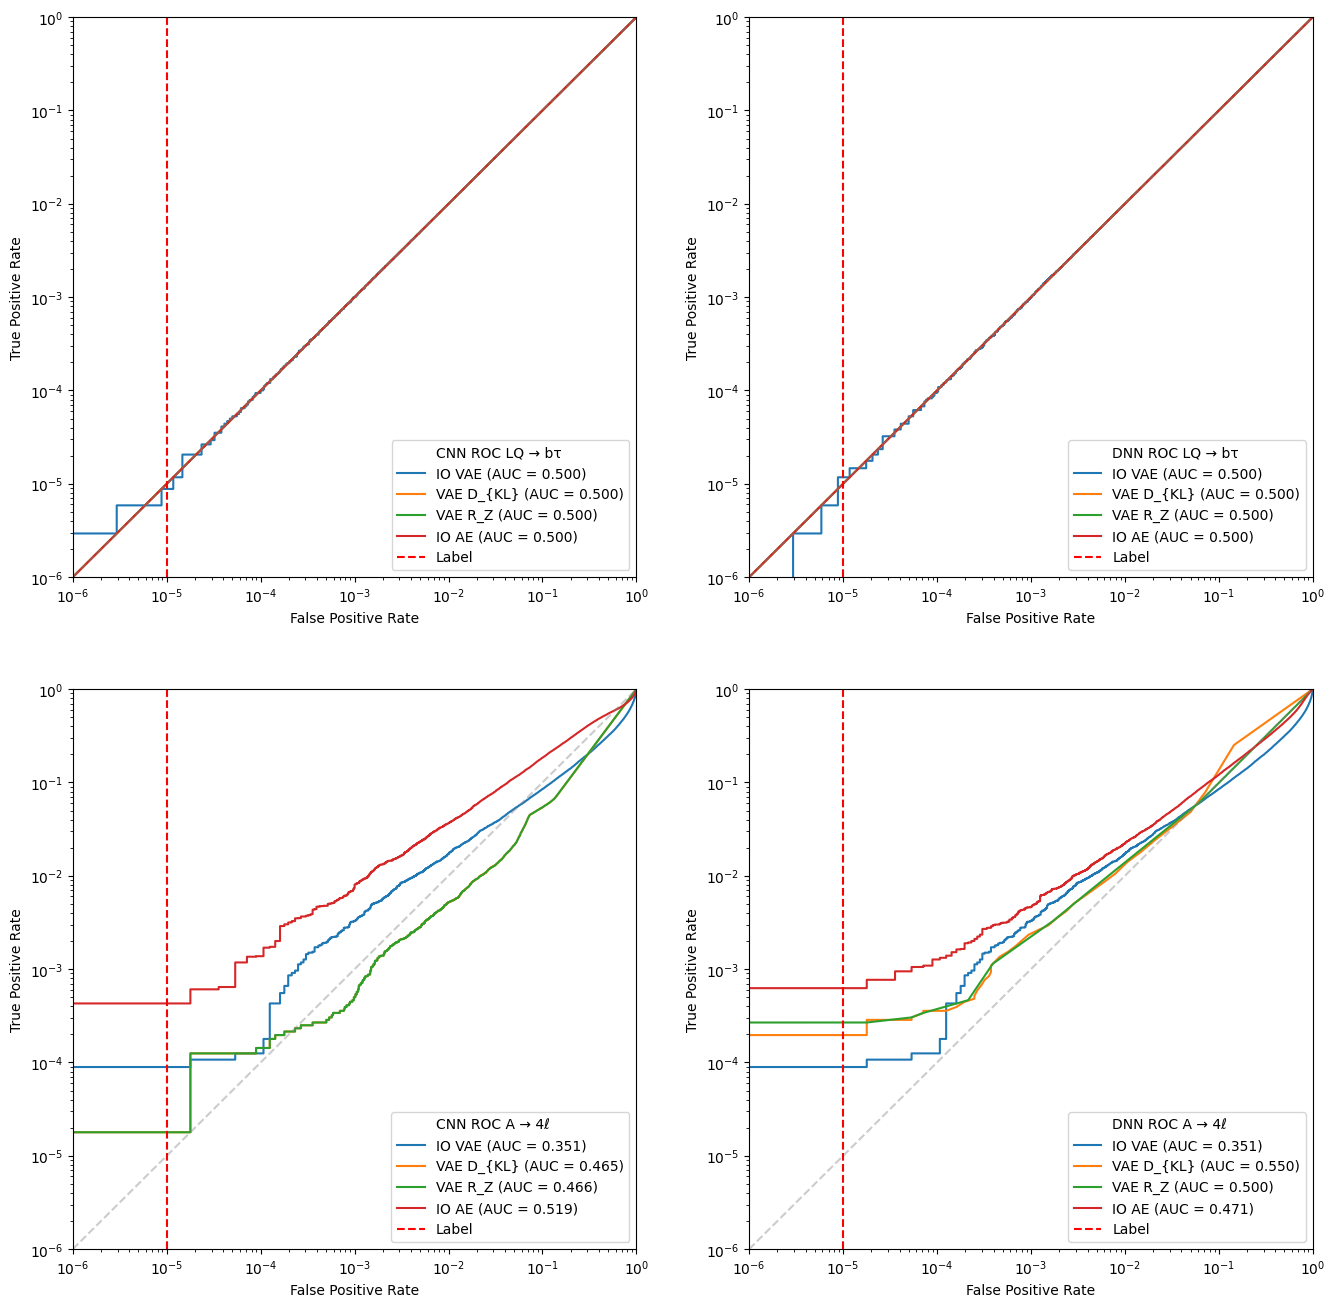

In [ ]:
from matplotlib.lines import Line2D
# For ROC we also need a background set lets use 1e5 background events 
background = h5py.File('/Code/Dataset/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5', 'r')['Particles'][:1000000,:,:3]
# ================================
# PLOT OUTLINE BASED ON THE PAPER
# ================================

# === FIGURE II: ROC Curves for CNN and DNN Models ===
# Data:
# - x-axis → False Positive Rate (FPR)
# - y-axis → True Positive Rate (TPR)
# - Models:
#   - CNN VAE (using IO, KL divergence, Rz scores)
#   - DNN VAE (using IO, KL divergence, Rz scores)
#   - CNN AE (using IO score)
#   - DNN AE (using IO score)
# Benchmark Models:
# - LQ → bτ
# - A → 4ℓ
# Method:
# - Compute ROC curves based on anomaly scores:
#   - MSE for AEs
#   - KL and Rz for VAEs
#   - Plot separate ROC curves for CNN and DNN
def figureII():
    def do_roc(ax, score, y_true, text):
        fpr, tpr, _ = roc_curve(y_true, score)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{text} (AUC = {roc_auc:.3f})')
    fig, ax = plt.subplots(2, 2, figsize=(16, 16))
    ax = ax.flatten()

    # CNN LQ -> bτ
    # Load SIGNAL ONLY Data
    dset = h5py.File('/Code/Dataset/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5', 'r')
    dset = dset['Particles'][:,:,:3]
    labels = np.ones(dset.shape[0])

    # Concatenate dset and background - Load as much bkground as data
    n_points = dset.shape[0]
    dset = np.concatenate([dset, background[:n_points]], axis=0)
    labels = np.concatenate([labels, np.zeros(n_points)])

    dset[:,:,0] = ((dset[:,:,0] - mean_pt) / std_pt)

    CNN_VAE = tf.keras.models.load_model('/Code/Replicate/Models/full_cnn_vae_beta1.0.keras')
    CNN_AE = tf.keras.models.load_model('/Code/Replicate/Models/full_cnn_ae.keras')

    cnn_io_vae = compute_io_score(dset, CNN_VAE.predict(dset)[:,:,:,0])
    do_roc(ax[0], cnn_io_vae.mean(axis=(1,2)), labels, "IO VAE")

    cnn_dkl_vae = compute_kl_score(*CNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[0], cnn_dkl_vae, labels, "VAE D_{KL}")

    cnn_Rz_vae = compute_rz_score(*CNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[0], cnn_Rz_vae, labels, "VAE R_Z")

    cnn_io_ae = compute_io_score(dset, CNN_AE.predict(dset)[:,:,:,0])
    do_roc(ax[0], cnn_io_ae.mean(axis=(1,2)), labels, "IO AE")


    
    # DNN LQ -> bτ
    DNN_VAE = tf.keras.models.load_model('/Code/Replicate/Models/full_dnn_vae_beta1.0.keras')
    DNN_AE = tf.keras.models.load_model('/Code/Replicate/Models/full_dnn_ae.keras')

    dnn_io_vae = compute_io_score(dset, DNN_VAE.predict(dset))
    do_roc(ax[1], dnn_io_vae.mean(axis=(1,2)), labels, "IO VAE")

    dnn_dkl_vae = compute_kl_score(*DNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[1], dnn_dkl_vae, labels, "VAE D_{KL}")    

    dnn_Rz_vae = compute_rz_score(*DNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[1], dnn_Rz_vae, labels, "VAE R_Z")

    dnn_io_ae = compute_io_score(dset, DNN_AE.predict(dset))
    do_roc(ax[1], dnn_io_ae.mean(axis=(1,2)), labels, "IO AE")


    # CNN A-> 4l
    dset = h5py.File('/Code/Dataset/Ato4l_lepFilter_13TeV_filtered.h5', 'r')
    dset = dset['Particles'][:,:,:3]
    labels = np.ones(dset.shape[0])

    # Concatenate dset and background
    n_points = dset.shape[0]
    dset = np.concatenate([dset, background[:n_points]], axis=0)
    labels = np.concatenate([labels, np.zeros(n_points)])

    cnn_io_vae = compute_io_score(dset, CNN_VAE.predict(dset)[:,:,:,0])
    do_roc(ax[2], cnn_io_vae.mean(axis=(1,2)), labels, "IO VAE")

    cnn_dkl_vae = compute_kl_score(*CNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[2], cnn_dkl_vae, labels, "VAE D_{KL}")

    cnn_Rz_vae = compute_rz_score(*CNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[2], cnn_Rz_vae, labels, "VAE R_Z")

    cnn_io_ae = compute_io_score(dset, CNN_AE.predict(dset)[:,:,:,0])
    do_roc(ax[2], cnn_io_ae.mean(axis=(1,2)), labels, "IO AE")


    # DNN A-> 4l
    dnn_io_vae = compute_io_score(dset, DNN_VAE.predict(dset))
    do_roc(ax[3], dnn_io_vae.mean(axis=(1,2)), labels, "IO VAE")

    dnn_dkl_vae = compute_kl_score(*DNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[3], dnn_dkl_vae, labels, "VAE D_{KL}")    

    dnn_Rz_vae = compute_rz_score(*DNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[3], dnn_Rz_vae, labels, "VAE R_Z")

    dnn_io_ae = compute_io_score(dset, DNN_AE.predict(dset))
    do_roc(ax[3], dnn_io_ae.mean(axis=(1,2)), labels, "IO AE")


    # And formating
    legend_text = [
        "CNN ROC LQ → bτ", 
        "DNN ROC LQ → bτ", 
        "CNN ROC A → 4ℓ",
        "DNN ROC A → 4ℓ"
    ]
    for i, a in enumerate(ax): 
        a.set_xlim(1e-6, 1)
        a.set_ylim(1e-6, 1)
        a.set_xscale('log')
        a.set_yscale('log')
        a.set_xlabel('False Positive Rate')
        a.set_ylabel('True Positive Rate')
        a.set_xticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0])
        a.set_yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0])
        a.grid(False)
        a.plot([1e-6, 1], [1e-6, 1], color='grey', linestyle='--', alpha=0.4)
        a.axvline(x=1e-5, color='red', linestyle='--', label='Label')
        # Add Legend Handle
        handles, labels = a.get_legend_handles_labels()
        # Create the custom text as a Line2D object
        extra = Line2D([0], [0], color='none', label='')
        # Insert at the beginning of the list
        handles.insert(0, extra)
        labels.insert(0, legend_text[i])
        a.legend(handles=handles, labels=labels, loc='lower right')

    plt.show()

figureII()


# === FIGURE III: Additional ROC Curves for CNN and DNN Models ===
# Data:
# - x-axis → False Positive Rate (FPR)
# - y-axis → True Positive Rate (TPR)
# - Models:
#   - CNN VAE (using IO, KL divergence, Rz scores)
#   - DNN VAE (using IO, KL divergence, Rz scores)
#   - CNN AE (using IO score)
#   - DNN AE (using IO score)
# Benchmark Models:
# - h± → τν
# - h0 → ττ
# Method:
# - Same as Figure II, but using different benchmark scenarios

def figureIII():
    def do_roc(ax, score, y_true, text):
        fpr, tpr, _ = roc_curve(y_true, score)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{text} (AUC = {roc_auc:.3f})')
    fig, ax = plt.subplots(2, 2, figsize=(16, 16))
    ax = ax.flatten()

    # CNN LQ -> bτ
    # Load SIGNAL ONLY Data
    dset = h5py.File('/Code/Dataset/hChToTauNu_13TeV_PU20_filtered.h5', 'r')
    dset = dset['Particles'][:,:,:3]
    labels = np.ones(dset.shape[0])

    # Concatenate dset and background - Load as much bkground as data
    n_points = dset.shape[0]
    dset = np.concatenate([dset, background[:n_points]], axis=0)
    labels = np.concatenate([labels, np.zeros(n_points)])

    dset[:,:,0] = ((dset[:,:,0] - mean_pt) / std_pt)

    CNN_VAE = tf.keras.models.load_model('/Code/Replicate/Models/full_cnn_vae_beta1.0.keras')
    CNN_AE = tf.keras.models.load_model('/Code/Replicate/Models/full_cnn_ae.keras')

    cnn_io_vae = compute_io_score(dset, CNN_VAE.predict(dset)[:,:,:,0])
    do_roc(ax[0], cnn_io_vae.mean(axis=(1,2)), labels, "IO VAE")

    cnn_dkl_vae = compute_kl_score(*CNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[0], cnn_dkl_vae, labels, "VAE D_{KL}")

    cnn_Rz_vae = compute_rz_score(*CNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[0], cnn_Rz_vae, labels, "VAE R_Z")

    cnn_io_ae = compute_io_score(dset, CNN_AE.predict(dset)[:,:,:,0])
    do_roc(ax[0], cnn_io_ae.mean(axis=(1,2)), labels, "IO AE")


    
    # DNN LQ -> bτ
    DNN_VAE = tf.keras.models.load_model('/Code/Replicate/Models/full_dnn_vae_beta1.0.keras')
    DNN_AE = tf.keras.models.load_model('/Code/Replicate/Models/full_dnn_ae.keras')

    dnn_io_vae = compute_io_score(dset, DNN_VAE.predict(dset))
    do_roc(ax[1], dnn_io_vae.mean(axis=(1,2)), labels, "IO VAE")

    dnn_dkl_vae = compute_kl_score(*DNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[1], dnn_dkl_vae, labels, "VAE D_{KL}")    

    dnn_Rz_vae = compute_rz_score(*DNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[1], dnn_Rz_vae, labels, "VAE R_Z")

    dnn_io_ae = compute_io_score(dset, DNN_AE.predict(dset))
    do_roc(ax[1], dnn_io_ae.mean(axis=(1,2)), labels, "IO AE")


    # CNN A-> 4l
    dset = h5py.File('/Code/Dataset/hToTauTau_13TeV_PU20_filtered.h5', 'r')
    dset = dset['Particles'][:,:,:3]
    labels = np.ones(dset.shape[0])

    # Concatenate dset and background
    n_points = dset.shape[0]
    dset = np.concatenate([dset, background[:n_points]], axis=0)
    labels = np.concatenate([labels, np.zeros(n_points)])

    cnn_io_vae = compute_io_score(dset, CNN_VAE.predict(dset)[:,:,:,0])
    do_roc(ax[2], cnn_io_vae.mean(axis=(1,2)), labels, "IO VAE")

    cnn_dkl_vae = compute_kl_score(*CNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[2], cnn_dkl_vae, labels, "VAE D_{KL}")

    cnn_Rz_vae = compute_rz_score(*CNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[2], cnn_Rz_vae, labels, "VAE R_Z")

    cnn_io_ae = compute_io_score(dset, CNN_AE.predict(dset)[:,:,:,0])
    do_roc(ax[2], cnn_io_ae.mean(axis=(1,2)), labels, "IO AE")


    # DNN A-> 4l
    dnn_io_vae = compute_io_score(dset, DNN_VAE.predict(dset))
    do_roc(ax[3], dnn_io_vae.mean(axis=(1,2)), labels, "IO VAE")

    dnn_dkl_vae = compute_kl_score(*DNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[3], dnn_dkl_vae, labels, "VAE D_{KL}")    

    dnn_Rz_vae = compute_rz_score(*DNN_VAE.encoder.predict(dset)[0:2])
    do_roc(ax[3], dnn_Rz_vae, labels, "VAE R_Z")

    dnn_io_ae = compute_io_score(dset, DNN_AE.predict(dset))
    do_roc(ax[3], dnn_io_ae.mean(axis=(1,2)), labels, "IO AE")


    # And formating
    legend_text = [
        "CNN ROC h± → τν", 
        "DNN ROC h± → τν", 
        "CNN ROC h0 → ττ",
        "DNN ROC h0 → ττ"
    ]
    for i, a in enumerate(ax): 
        a.set_xlim(1e-6, 1)
        a.set_ylim(1e-6, 1)
        a.set_xscale('log')
        a.set_yscale('log')
        a.set_xlabel('False Positive Rate')
        a.set_ylabel('True Positive Rate')
        a.set_xticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0])
        a.set_yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0])
        a.grid(False)
        a.plot([1e-6, 1], [1e-6, 1], color='grey', linestyle='--', alpha=0.4)
        a.axvline(x=1e-5, color='red', linestyle='--', label='Label')
        # Add Legend Handle
        handles, labels = a.get_legend_handles_labels()
        # Create the custom text as a Line2D object
        extra = Line2D([0], [0], color='none', label='')
        # Insert at the beginning of the list
        handles.insert(0, extra)
        labels.insert(0, legend_text[i])
        a.legend(handles=handles, labels=labels, loc='lower right')

    plt.show()

# figureIII()

# === FIGURE IV: TPR Ratio vs. Bit Width for AE Models ===
# Data:
# - x-axis → Bit width (2, 4, 6, 8, 10, 12, 14, 16)
# - y-axis → TPR ratio (TPR for quantized model / TPR for baseline model)
# - Models:
#   - CNN AE (top left)
#   - DNN AE (top right)
#   - CNN AE (bottom left, QAT)
#   - DNN AE (bottom right, QAT)
# Method:
# - Use MSE-based anomaly score for AE models
# - Compute TPR ratio at FPR = 10⁻⁵

# === FIGURE V: TPR Ratio vs. Bit Width for VAE Models ===
# Data:
# - x-axis → Bit width (2, 4, 6, 8, 10, 12, 14, 16)
# - y-axis → TPR ratio (TPR for quantized model / TPR for baseline model)
# - Models:
#   - CNN VAE (top left)
#   - DNN VAE (top right)
#   - CNN VAE (bottom left, QAT)
#   - DNN VAE (bottom right, QAT)
# Method:
# - Use KL-based anomaly score for VAE models
# - Compute TPR ratio at FPR = 10⁻⁵

# === TABLE I: Performance Table at Floating-Point Precision ===
# Data:
# - Models:
#   - CNN AE, CNN VAE
#   - DNN AE, DNN VAE
# - AD Scores:
#   - IO (MSE)
#   - KL divergence
#   - Rz score
# - Benchmark Models:
#   - LQ → bτ
#   - A → 4ℓ
#   - h± → τν
#   - h0 → ττ
# - Metrics:
#   - AUC
#   - TPR @ FPR = 10⁻⁵

# === TABLE II: Performance of Quantized and Pruned Models ===
# Data:
# - Models:
#   - CNN AE (QAT 4-bit)
#   - CNN VAE (PTQ 8-bit)
#   - DNN AE (QAT 8-bit)
#   - DNN VAE (PTQ 8-bit)
# - AD Scores:
#   - IO (MSE)
#   - KL divergence
#   - Rz score
# - Metrics:
#   - AUC
#   - TPR @ FPR = 10⁻⁵

# === TABLE III: FPGA Resource Usage and Latency ===
# Data:
# - Models:
#   - CNN AE (QAT 4-bit)
#   - CNN VAE (PTQ 8-bit)
#   - DNN AE (QAT 8-bit)
#   - DNN VAE (PTQ 8-bit)
# - Metrics:
#   - DSP usage (%)
#   - LUT usage (%)
#   - Flip-Flop usage (%)
#   - BRAM usage (%)
#   - Latency (ns)
#   - Initiation interval (ns)

# === TABLE IV: FPGA Resource Usage for DNN AE ===
# Data:
# - Model:
#   - DNN VAE (PTQ 8-bit)
# - Metrics:
#   - DSP usage (%)
#   - LUT usage (%)
#   - Flip-Flop usage (%)
#   - BRAM usage (%)
#   - Latency (ns)
#   - Initiation interval (ns)
# - Results are for a Xilinx V7-690 FPGA



In [27]:
import os
import tensorflow as tf
from functools import partial


# Quantize 

In [32]:
model.encoder.predict(data[:10, :, :3, None])[-1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


array([[ 0.43935484,  0.8376833 ,  0.062288  , -0.6048376 ,  0.8403199 ,
        -1.0819213 , -0.13142052,  0.295651  ],
       [ 0.3752639 ,  0.9664562 ,  0.02141817, -0.70870644,  0.6433484 ,
        -0.6553092 , -0.42160138,  0.36034805],
       [-0.12028702,  0.61757094,  0.71783084, -0.7247662 ,  0.49963015,
        -0.8521857 ,  0.04340982,  0.14980876],
       [ 0.56379163,  0.47975177, -0.70673245,  0.06451288,  0.66555554,
        -0.52172554,  1.0914093 , -0.9185903 ],
       [-0.15444665,  1.1766489 ,  0.08015898, -0.3762616 , -0.26573992,
         0.679626  ,  1.4763689 , -0.1389284 ],
       [ 0.569395  ,  0.5164971 , -0.71120274,  0.01360121,  0.32494396,
        -0.20082077, -0.48997006,  1.133576  ],
       [ 0.5218977 ,  0.6808742 , -0.44234946,  0.03640291,  0.44861788,
         0.06669156, -0.15802635, -0.89189297],
       [-0.13290274,  1.3633995 ,  0.8628346 ,  0.5781877 ,  0.30392948,
        -1.1694325 , -0.70004135,  0.05082234],
       [ 0.023442  ,  0.19666673